In [25]:
import numpy as np
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
import re
import string

def remove_html_tag(text):
    return re.sub(
        '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',
        '', text)

In [27]:
df = pd.read_csv('IMDB_Dataset.csv')
df['clean_text'] = df.review.apply(remove_html_tag)
df

,review,sentiment,clean_text
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...


In [28]:
df.clean_text.apply(lambda x: len(x.split(' '))).describe()

,clean_text
count,50000.00000
mean,227.10428
std,168.26324
min,4.00000
25%,124.00000
50%,170.00000
75%,275.00000
max,2450.00000


In [29]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

df_train = df.sample(n=3000, random_state=42).reset_index(drop=True)
df_test = df.sample(n=300, random_state=42).reset_index(drop=True)

In [30]:
class BertDataset(torch.utils.data.Dataset):
    def __init__(self, df, bert_model_name='bert-base-cased'):
        self.review = df.clean_text
        self.sentiment = df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
        self.tokenizer = BertTokenizerFast.from_pretrained(bert_model_name)

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        x = self.tokenize(self.review[idx])
        for key in x:
            x[key] = x[key].view(-1).to(device)
        y = self.sentiment[idx]
        return x, y

    def tokenize(self, x):
        x = self.tokenizer(x, max_length=256, padding='max_length',
                              truncation=True, return_tensors='pt')
        return x

In [31]:
from transformers import BertTokenizerFast

trainloader = torch.utils.data.DataLoader(BertDataset(df_train), batch_size=32)
testloader = torch.utils.data.DataLoader(BertDataset(df_test), batch_size=32)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
from transformers import BertModel

class BertClassifier(torch.nn.Module):
    def __init__(self, bert_model_name='bert-base-cased', bert_freeze=False):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = False if bert_freeze else True
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(input_ids, attention_mask, token_type_ids).pooler_output
        out = self.dropout(out)
        out = torch.sigmoid(self.classifier(out)).view(-1)
        return  out

In [33]:
model = BertClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), 2e-5)
loss = torch.nn.BCELoss()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [34]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train(epoch, model, optimizer, loss_fn, dataloader):
    # Enable training
    model.train()
    with tqdm(dataloader, total=len(dataloader)) as pbar:
        accuracy = []
        losses = []
        pbar.set_description('Epoch %d - Training\t' %(epoch + 1))
        for x, y in pbar:
            # zero the parameter gradients
            optimizer.zero_grad()

            # Convert label for specified device and to float type
            y = y.to(device).float()

            # Update weights and parameters by, forward + backward + optimize
            y_pred = model(**x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            # Convert tensors to CPU mode and integer type
            y = y.cpu().int()
            y_pred = (y_pred > 0.5).cpu().int()

            # Add metrics record to lists
            accuracy.append(accuracy_score(y, y_pred))
            losses.append(loss.item())

            # Store average of metrics
            history = {'training_loss': np.mean(losses),
                       'training_accuracy': np.mean(accuracy)}
            # Update progress bar
            pbar.set_postfix(history)
        return history

def evaluate(epoch, model, loss_fn, dataloader):
    # Disable training
    model.eval()
    with torch.no_grad(), tqdm(dataloader, total=len(dataloader)) as pbar:
        accuracy = []
        losses = []
        pbar.set_description('Epoch %d - Validation\t' %(epoch + 1))
        for x, y in pbar:
            # Generate prediction
            y_pred = model(**x)

            # Convert label for specified device and to float type
            y = y.to(device).float()

            # Compute loss
            loss = loss_fn(y_pred, y)

            # Convert tensors to CPU mode and integer type
            y_pred = (y_pred > 0.5).cpu().int()
            y = y.cpu().int()

            # Add metrics record to lists
            accuracy.append(accuracy_score(y, y_pred))
            losses.append(loss.item())

            # Store average of metrics
            history = {'validation_loss': np.mean(losses),
                       'validation_accuracy': np.mean(accuracy)}

            # Update progress bar
            pbar.set_postfix(history)
        return history

In [35]:
history = [{**train(epoch, model, optimizer, loss, trainloader),
            **evaluate(epoch, model, loss, testloader)}
           for epoch in range(5)]

Epoch 5 - Validation	: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s, validation_loss=0.029, validation_accuracy=0.989]


In [36]:
training_loss = [h['training_loss'] for h in history]
validation_loss = [h['validation_loss'] for h in history]
training_accuracy = [h['training_accuracy'] for h in history]
validation_accuracy = [h['validation_accuracy'] for h in history]

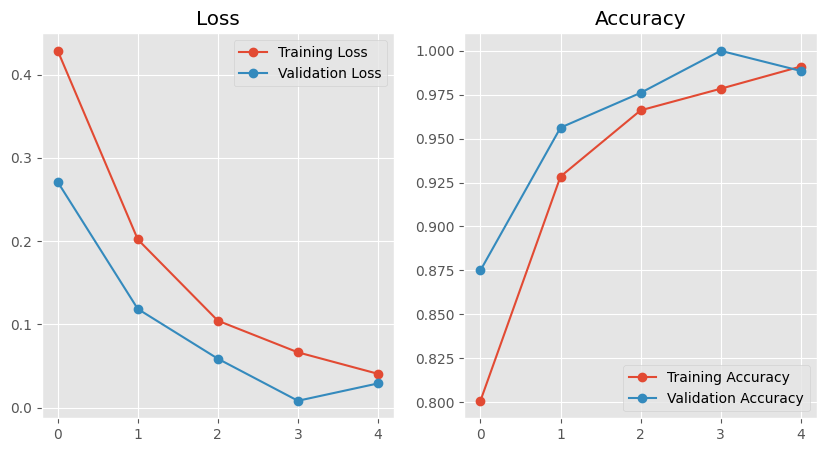

In [37]:
import matplotlib.pyplot as plt

# Change to a style that works well in Google Colab
plt.style.use('ggplot')

# Initialize plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
# Left plot
ax1.set_title('Loss')
ax1.plot(training_loss, 'o-', label='Training Loss')
ax1.plot(validation_loss, 'o-', label='Validation Loss')
ax1.legend()
# Right plot
ax2.set_title('Accuracy')
ax2.plot(training_accuracy, 'o-', label='Training Accuracy')
ax2.plot(validation_accuracy, 'o-', label='Validation Accuracy')
ax2.legend()
fig.show()

Trying with larger dataset

In [38]:
df_train = df.sample(n=500, random_state=42).reset_index(drop=True)
df_test = df.sample(n=50, random_state=42).reset_index(drop=True)

In [39]:
from transformers import BertTokenizerFast

trainloader = torch.utils.data.DataLoader(BertDataset(df_train), batch_size=32)
testloader = torch.utils.data.DataLoader(BertDataset(df_test), batch_size=32)

In [41]:
history = [{**train(epoch, model, optimizer, loss, trainloader),
            **evaluate(epoch, model, loss, testloader)}
           for epoch in range(3)]

Epoch 3 - Validation	: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, validation_loss=0.00222, validation_accuracy=1]


In [42]:
training_loss = [h['training_loss'] for h in history]
validation_loss = [h['validation_loss'] for h in history]
training_accuracy = [h['training_accuracy'] for h in history]
validation_accuracy = [h['validation_accuracy'] for h in history]

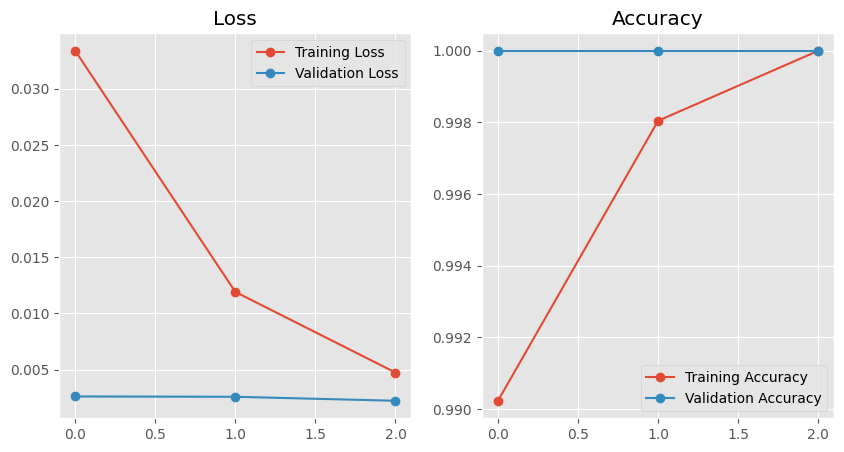

In [43]:
# Change to a style that works well in Google Colab
plt.style.use('ggplot')

# Initialize plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
# Left plot
ax1.set_title('Loss')
ax1.plot(training_loss, 'o-', label='Training Loss')
ax1.plot(validation_loss, 'o-', label='Validation Loss')
ax1.legend()
# Right plot
ax2.set_title('Accuracy')
ax2.plot(training_accuracy, 'o-', label='Training Accuracy')
ax2.plot(validation_accuracy, 'o-', label='Validation Accuracy')
ax2.legend()
fig.show()

In [ ]:
# Step 8: Predicting sentiment for new data
def predict_sentiment(model, text_data, device, tokenizer): # Add tokenizer as argument
    model.eval()
    # Use BertTokenizerFast instead of Berttokenizer
    encodings = tokenizer(text_data, truncation=True, padding=True, max_length=128, return_tensors='pt') # Use provided tokenizer
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    token_type_ids = encodings.get('token_type_ids', None)  # Get token_type_ids

    # Move token_type_ids to the correct device if it exists
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    with torch.no_grad():
        # Pass necessary inputs to the model
        output = model(input_ids, attention_mask, token_type_ids)

    # Apply sigmoid to get probability, and convert to 0/1 class
    preds = output.squeeze().cpu().numpy()
    preds = [1 if p > 0.45 else 0 for p in preds]  # Convert to 1 for positive sentiment, 0 for negative

    return preds

# Example: Predict sentiment for new text
#likely  will have to change new text to previous dataset
new_text = ["joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried first party lost",
                 "miller conducting mass mailing campaign advertise sale adult material convicted violating california statute prohibiting distribution obscene material unwilling recipients millers brochures complained police initiating legal proceedings first party lost",
                 "ernest e mandel belgian professional charged with speeding ticket proved innocent proof for case was found through the highway traffic cams first party won",
                 "officer judy hopps and newly appointed junior officer nick wilde successfully captured mayor bellweather case solved",
                 "there was a couple that was found fit to raise their children and was given custody from the state,  they were previous accused of neglect, though  with no true evidence against them, the case was dropped and the child was returned to their rightful family"]
# Get the tokenizer used in your BertDataset class
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
predictions = predict_sentiment(model, new_text, device, tokenizer) # Pass tokenizer to predict_sentiment

print(predictions)  # Output should be [1, 0] indicating positive and negative sentiments

[0, 0, 0, 1, 1]


Bert IMDB Trained Case  

In [44]:
new_text = ["joan stanley three children peter stanley stanleys never married lived together years joan died state illinois took children illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state peter appealed decision arguing illinois law violated equal protection clause fourteenth amendment unwed mothers deprived children without showing actually unfit parents illinois supreme court rejected stanleys equal protection claim holding actual fitness parent irrelevant childrens mother unmarried first party lost",
                 "miller conducting mass mailing campaign advertise sale adult material convicted violating california statute prohibiting distribution obscene material unwilling recipients millers brochures complained police initiating legal proceedings first party lost",
                 "ernest e mandel belgian professional charged with speeding ticket proved innocent proof for case was found through the highway traffic cams first party won",
                 "officer judy hopps and newly appointed junior officer nick wilde successfully captured mayor bellweather case solved",
                 "there was a couple that was found fit to raise their children and was given custody from the state,  they were previous accused of neglect, though  with no true evidence against them, the case was dropped and the child was returned to their rightful family"]

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-imdb")
results = pipe(new_text)
results

Device set to use cuda:0


[{'label': 'neg', 'score': 0.9823548197746277},
 {'label': 'neg', 'score': 0.9981698989868164},
 {'label': 'pos', 'score': 0.9913153648376465},
 {'label': 'pos', 'score': 0.9875164031982422},
 {'label': 'neg', 'score': 0.9874128103256226}]

In [2]:
!pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 14.8 MB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from symspellpy import SymSpell

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
import os.path
# Download and Load the SymSpell Dict

!wget -q https://github.com/mammothb/symspellpy/raw/master/symspellpy/frequency_dictionary_en_82_765.txt
# Initialize SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "/content/frequency_dictionary_en_82_765.txt"

# Check if dictionary path exists already, delete before creating
if os.path.exists(dictionary_path):
  !rm -f /content/frequency_dictionary_en_82_765.txt
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Returns cleaned text. Requires raw text (str) arg. Optional start (int), end (int) args.
def data_preprocessor(raw_text, start=None, end=None):

    # Clean text: Remove punctuations, all lowercase, strip(), remove any numbers
    cleaned_text = re.sub(r'[^\w\s]|\d+', '', str(raw_text).lower().strip())

    # Correct Spelling
    correction = sym_spell.lookup_compound(cleaned_text, max_edit_distance=2)
    corrected_text = correction[0].term if correction else cleaned_text # Extract only the corrected term.


    # Step 2: Tokenize text
    tokens = word_tokenize(corrected_text) #

    # Step 3: Remove stopwords (After spell correction)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Step 4: Join all tokens into one string.
    final_text = ' '.join(filtered_tokens[start:end]) # Filter out unnecessary web info.

    return final_text

In [5]:
from nltk.corpus import stopwords # Already imported earlier but safer to reimport

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

lem = WordNetLemmatizer()

# Function to map POS tags to WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'a'  # Adjective


# Function to lemmatize a tokenized dataset
def lemmatize_tokens(token_list):
    tagged_tokens = pos_tag(token_list)  # Apply POS tagging
    lemmatized_tokens = [
        lem.lemmatize(token, get_wordnet_pos(tag))
        for token, tag in tagged_tokens if token not in stop_words and len(token) > 1
    ]
    return ' '.join(lemmatized_tokens)  # Convert list back to a string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Import dataset
df = pd.read_csv('justice.csv')

# Drop rows with NA
df.dropna(inplace=True)
df.head()

# Create a backup of the dataset in case we need to go back to OG
df1 = df.copy()

# Drop irrelevant columns
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area',
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [8]:
df_cat = df1[['decision_type', 'disposition']]
df_target = df1[['first_party_winner']]
df_nlp = df1[['facts']]

# Reset indices to avoid NaNs during concatentation and One-Hot Encoding
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [9]:
# One-Hot Encoding
label_encoder = LabelEncoder()
df_target = label_encoder.fit_transform(df_target)

# Change into Pandas Dataframe
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1.head()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,first_party_winner
0,1
1,1
2,1
3,1
4,1


In [10]:
nltk.download('punkt_tab')

# Reassemble the dataframe with the one-hot encoded column
df_concat = pd.concat([df_cat, df_target1], axis=1, join='inner')
df_concat.head()

# Apply our text preprocessing on the facts column
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)

# Split into tokens and use our preprocessor function
df_nlp1['facts_clean'] = df_nlp1['facts'].apply(lambda x: data_preprocessor(str(x)))
df_nlp1.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three children peter stanley stan...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified males must prefer...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...


In [11]:
# Reassemble the facts column with the first_party_winner column
df_nlp2 = pd.concat([df_nlp1, df_target1['first_party_winner']], axis=1, join='inner')
df_nlp2.head()

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three children peter stanley stan...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified males must prefer...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1


In [19]:
# Store a list of cleaned legal case texts
cleaned_legal = []

# Add 'party won' or 'party lost' at the end of text based on df_nlp2['first_party_winner']
for won_case in df_nlp2[df_nlp2['first_party_winner'] == 1]['facts_clean'].values.tolist():
  cleaned_legal.append(won_case + ' party won')

for lost_case in df_nlp2[df_nlp2['first_party_winner'] == 0]['facts_clean'].values.tolist():
  cleaned_legal.append(lost_case + ' party lost')

# Take 50 random cases
clean_50_legal = np.random.choice(cleaned_legal, 50)

In [20]:
# Send list to pipeline
legal_clean_results = pipe(clean_50_legal.tolist())

In [21]:
legal_clean_results

[{'label': 'neg', 'score': 0.9749465584754944},
 {'label': 'neg', 'score': 0.9977387189865112},
 {'label': 'pos', 'score': 0.5392899513244629},
 {'label': 'neg', 'score': 0.9935235977172852},
 {'label': 'neg', 'score': 0.9827941656112671},
 {'label': 'neg', 'score': 0.9935465455055237},
 {'label': 'neg', 'score': 0.9967541098594666},
 {'label': 'neg', 'score': 0.9192080497741699},
 {'label': 'neg', 'score': 0.9942339062690735},
 {'label': 'neg', 'score': 0.917547881603241},
 {'label': 'neg', 'score': 0.9949093461036682},
 {'label': 'neg', 'score': 0.993179202079773},
 {'label': 'neg', 'score': 0.9957595467567444},
 {'label': 'neg', 'score': 0.9944942593574524},
 {'label': 'neg', 'score': 0.9979948997497559},
 {'label': 'pos', 'score': 0.8729909658432007},
 {'label': 'neg', 'score': 0.9940774440765381},
 {'label': 'pos', 'score': 0.5238684415817261},
 {'label': 'pos', 'score': 0.9699867367744446},
 {'label': 'neg', 'score': 0.9983474016189575},
 {'label': 'neg', 'score': 0.9923967719078

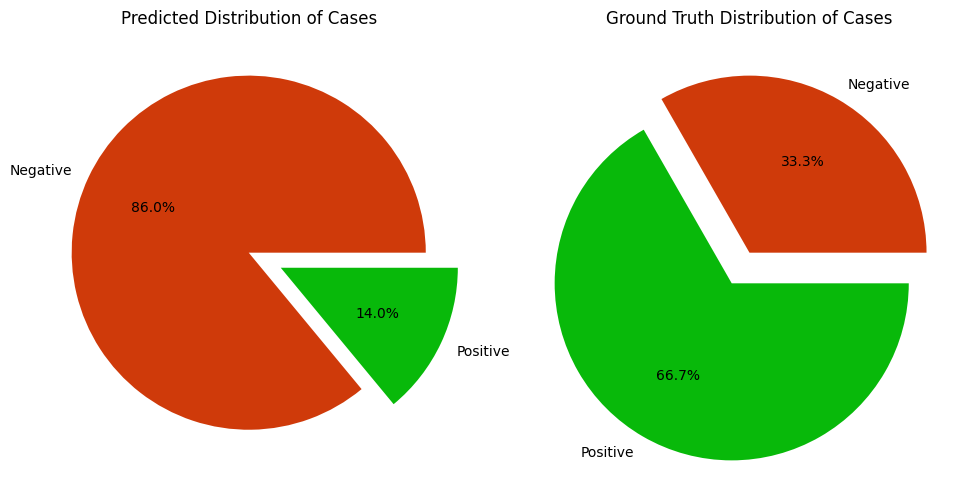

In [23]:
# create pie chart of the label distribution
import matplotlib.pyplot as plt
import numpy as np

counts = [0, 0]
explode = [0, 0.2]
colors = ['#cf3a0a', '#08b90a']
labels = ['Negative', 'Positive']

# Count negative and positive from models predictions
for label in legal_clean_results:
  if label['label'] == 'neg':
    counts[0] += 1
  else:
    counts[1] += 1

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Show the predicted # of pos and neg cases
ax1.pie(counts, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax1.set_title('Predicted Distribution of Cases')

# Show the true # of pos and neg cases from ground truth
ax2.pie([df_nlp2[df_nlp2['first_party_winner'] == 0].count().values[0], df_nlp2[df_nlp2['first_party_winner'] == 1].count().values[0]], labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax2.set_title('Ground Truth Distribution of Cases')

# Prevent overlap between charts
plt.tight_layout()

plt.show()

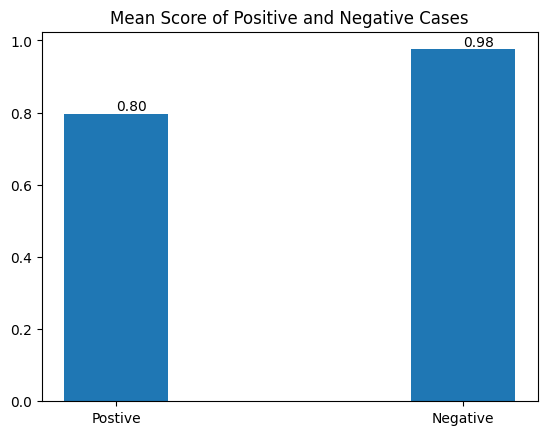

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statistics import mean

# Show score levels of positives and negatives
labels = ['Negative', 'Positive', 'Overall']

df = pd.DataFrame(legal_clean_results)

# Get mean score of both labels
pos_mean = mean(df[df['label'] == 'pos']['score'].values.tolist())
neg_mean = mean(df[df['label'] == 'neg']['score'].values.tolist())

plt.bar(['Postive', 'Negative'], [pos_mean, neg_mean], width=0.3)

# Display the mean scores
plt.text('Postive', pos_mean, f'{pos_mean:.2f}', va='bottom')
plt.text('Negative', neg_mean, f'{neg_mean:.2f}', va='bottom')

# Add title
plt.title('Mean Score of Positive and Negative Cases')
plt.show()

Jaidyn's Personal Fine Tuned Model Testing on 50 Random Cases

In [47]:
# Step 8: Predicting sentiment for new data
def predict_sentiment(model, text_data, device, tokenizer): # Add tokenizer as argument
    model.eval()
    # Use BertTokenizerFast instead of Berttokenizer
    encodings = tokenizer(text_data, truncation=True, padding=True, max_length=128, return_tensors='pt') # Use provided tokenizer
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    token_type_ids = encodings.get('token_type_ids', None)  # Get token_type_ids

    # Move token_type_ids to the correct device if it exists
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    with torch.no_grad():
        # Pass necessary inputs to the model
        output = model(input_ids, attention_mask, token_type_ids)

    # Apply sigmoid to get probability, and convert to 0/1 class
    preds = output.squeeze().cpu().numpy()
    preds = [1 if p > 0.45 else 0 for p in preds]  # Convert to 1 for positive sentiment, 0 for negative

    return preds


# Get the tokenizer used in your BertDataset class
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
predictions = predict_sentiment(model, clean_50_legal.tolist(), device, tokenizer) # Pass tokenizer to predict_sentiment

print(predictions)  # Output should be [1, 0] indicating positive and negative sentiments

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


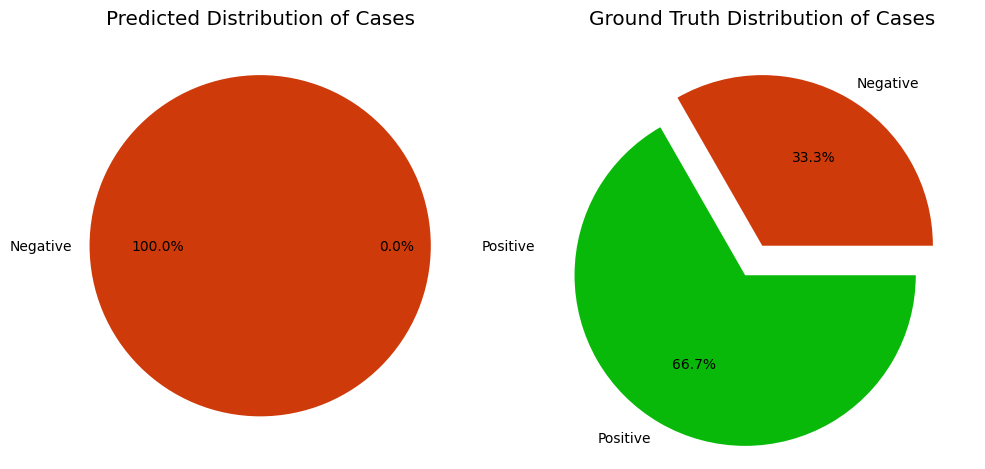

In [48]:
# create pie chart of the label distribution
import matplotlib.pyplot as plt
import numpy as np

counts = [0, 0]
explode = [0, 0.2]
colors = ['#cf3a0a', '#08b90a']
labels = ['Negative', 'Positive']

# Count negative and positive from models predictions
for pred in predictions:
  if pred == 0:
    counts[0] += 1
  else:
    counts[1] += 1

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Show the predicted # of pos and neg cases
ax1.pie(counts, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax1.set_title('Predicted Distribution of Cases')

# Show the true # of pos and neg cases from ground truth
ax2.pie([df_nlp2[df_nlp2['first_party_winner'] == 0].count().values[0], df_nlp2[df_nlp2['first_party_winner'] == 1].count().values[0]], labels=labels, autopct='%1.1f%%', explode=explode, colors=colors)
ax2.set_title('Ground Truth Distribution of Cases')

# Prevent overlap between charts
plt.tight_layout()

plt.show()